### 単射となる変換のみを考える

In [4]:
import pickle
import os
import torch
from torchvision import datasets, transforms

from shift_funcs import get_funcs
import numpy as np

SEED = 0
SAMPLE_SIZE = 1000

In [5]:
# def augument_data(source):
#     data = []
#     for c in source:
#         new = [
#             c,
#             np.rot90(c, np.random.randint(1, 4)),
#             np.fliplr(c),
#             np.flipud(c)                
#         ]
#         data.extend(new)
#     data = np.array(data, dtype=source.dtype)
#     return data

In [6]:
def apply(original_set, filter_indices_set, funcs):  
    dataset = []
    for k, indices in enumerate(filter_indices_set):
        img = original_set[k]
        det_img = img.copy()
        for i in indices:
            func, _ = funcs[i]
            det_img = func(det_img)
        dataset.append(det_img)
    return np.array(dataset)

In [7]:
def create_train_dataset(func_indices, shift_len, C=3, fname='', seed=SEED, size=SAMPLE_SIZE):
    funcs = [get_funcs(*delta) for delta in [
        (shift_len, shift_len),
        (shift_len, -shift_len),
        (-shift_len, shift_len),
        (-shift_len, -shift_len),
    ]]

    np.random.seed(seed)
    train_dataset = datasets.MNIST(root='../open_data/', train=True, download=True)
    idx = np.random.choice(train_dataset.data.shape[0], size)
    imgs = train_dataset.data[idx].numpy()
#     augumented_dataset = augument_data(imgs)
    originals = imgs
    originals = originals / 255

    train_filter_set = np.random.choice(func_indices, (originals.shape[0], C))
    train_dataset = apply(originals, train_filter_set, funcs)

    np.savez(
        os.path.join('data', fname),
        train_dataset=train_dataset,
        train_func_labels=train_filter_set,
        original_dataset=originals,
    )

In [8]:
# テストデータ
def create_test_dataset(shift_len, func_indices, fname=''):
    funcs = [get_funcs(*delta) for delta in [
        (shift_len, shift_len),
        (shift_len, -shift_len),
        (-shift_len, shift_len),
        (-shift_len, -shift_len),
    ]]
    
    np.random.seed(SEED + 1000)
    originals = datasets.MNIST(root='../open_data/', train=False, download=True).data.numpy()
    originals = originals / 255    
    test_filter_set = np.random.choice(func_indices, (originals.shape[0], 3))
    
    test_dataset = apply(originals, test_filter_set, funcs)
    np.savez(
        os.path.join('data', fname),
        test_dataset=test_dataset,
        original_dataset=originals,
        test_func_labels=test_filter_set,
    )

In [9]:
def create_dataset(shift_len):
    os.makedirs('data/shift%d' % shift_len, exist_ok=True)
    create_test_dataset(shift_len=shift_len, func_indices=[0], fname='shift%d/test_0_dataset.npz' % shift_len)
    create_test_dataset(shift_len=shift_len, func_indices=[0, 3], fname='shift%d/test_03_dataset.npz' % shift_len)
    create_test_dataset(shift_len=shift_len, func_indices=[1], fname='shift%d/test_1_dataset.npz' % shift_len)

    # f: forward, b: backward
    create_train_dataset(func_indices=[0], shift_len=shift_len, fname='shift%d/diag_xfyf_dataset.npz' % shift_len)
    create_train_dataset(func_indices=[0, 3], shift_len=shift_len, fname='shift%d/diag_xfyf_xbyb_dataset.npz' % shift_len)

### 1. シフト1のデータセットを作成する

In [10]:
create_dataset(shift_len=1)

### 2. シフト2のデータセットを作成する

In [11]:
create_dataset(shift_len=2)

### 2. シフト3のデータセットを作成する

In [12]:
create_dataset(shift_len=3)

In [58]:
shift_len = 2
seed = 0
size = 1000
funcs = [get_funcs(*delta) for delta in [(shift_len, shift_len), (shift_len, 0), (0, shift_len)]]

np.random.seed(seed)
train_dataset = datasets.MNIST(root='../open_data/', train=True, download=True)
idx = np.random.choice(train_dataset.data.shape[0], size)
imgs = train_dataset.data[idx].numpy()
augumented_dataset = augument_data(imgs)

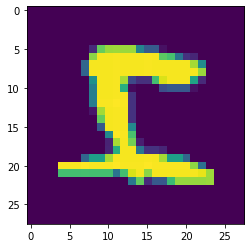

-138.18112244897958


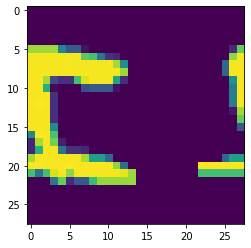

In [61]:
from matplotlib import pyplot as plt
img = augumented_dataset[1]

plt.imshow(img)
plt.show()


o_img = img.copy()
r = 0
for _ in range(5):
    o_img = funcs[2][1](o_img)
    r -= np.mean((o_img - img)**2)
print(r)
plt.imshow(o_img)
plt.show()